# FEATURES

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
# download data here https://www.kaggle.com/competitions/aim-2024-callcenter

df_train = pd.read_csv('train.csv')
df_test  = pd.read_csv('test.csv')
df_sessions = pd.read_csv('t1_webstat.csv')

In [3]:
def make_session_features(df_sessions):
  df_sessions['date_time'] = pd.to_datetime(df_sessions['date_time'])

  aggregations = dict(
    date_time =  lambda x: (x.max() - x.min()).total_seconds(),
    pageview_number =  'max',
    price = [lambda x: np.nansum(x), lambda x: np.nanmean(x), 'max', 'min'],

    product_in_sale = [lambda x: np.nansum(x), lambda x: np.nanmean(x)],
    category_id = ['nunique', lambda x: int(pd.isna(x.iloc[-1]))],
    good_id = 'nunique',
    model_id = 'nunique',

    pageview_duration_sec = [lambda x: np.nansum(x), lambda x: sum([i for i in x if i>0]), lambda x: np.nanmedian(x), lambda x: int(pd.isna(x.iloc[-1]))],
    page_type = [lambda x: x.iloc[-1], lambda x: int(np.nanmean(pd.Series.mode(x)))]
  )
  session_stats = df_sessions.groupby('sessionkey_id').agg(aggregations)
  session_stats.columns = [
    'session_duration', 'session_max_pageview_number', 'session_sum_price', 'session_mean_price', 'session_max_price', 'session_min_price',
    'session_num_products_in_sale', 'session_mean_products_in_sale', 'session_nunique_categories', 'session_category_id_ends_NaN', 'session_unique_goods', 'session_unique_models',
    'session_sum_pageview_duration', 'session_positiveSum_pageview_duration', 'session_median_pageview_duration', 'session_pageview_ends_NaN', 'session_last_page_type', 'session_most_frequent_page_type'
    ]
  session_stats['session_num_nans'] = df_sessions.groupby('sessionkey_id').apply(lambda x: x.isna().sum().sum())
  return session_stats

def add_all_feaures(df, session_stats):
  # useless ftrs;
  df['price*qty'] = df['price']*df['goods_qty']
  df['create_month'] = pd.to_datetime(df['create_time']).dt.month.values
  df['create_week'] = pd.to_datetime(df['create_time']).dt.day_of_week.values
  df['create_hour'] = pd.to_datetime(df['create_time']).dt.hour.values
  df['1StarRatingChange'] = (df['rating_value']*df['rating_count']+1)/(df['rating_count']+1)

  # session and log features
  df = df.merge(session_stats, how='left', left_on='sessionkey_id', right_index=True)
  df['session_duration_diff'] = df['session_duration'] - df['session_sum_pageview_duration']
  df['session_duration_positive_diff'] = df['session_duration'] - df['session_positiveSum_pageview_duration']
  LOGFEATURES = [
    'price', 'price*qty', 'rating_count', 'session_duration', 'description_length', 
    'session_mean_price', 'session_max_price', 'session_num_nans', 
    'session_sum_pageview_duration', 'session_positiveSum_pageview_duration', 'session_median_pageview_duration'
    ]
  for feature in LOGFEATURES: df['log_'+feature] =  df[feature].clip(0).apply(np.log1p)
  df['session_duration_log_diff'] = df['log_session_duration'] - df['log_session_sum_pageview_duration']
  df['session_duration_positive_log_diff'] = df['log_session_duration'] - df['log_session_positiveSum_pageview_duration']
  return df


session_stats = make_session_features(df_sessions)
df_train = add_all_feaures(df_train, session_stats)
# df_test = add_all_feaures(df_test, session_stats)


# train_test_good_model_ids_intersection = df_test.model_id.isin(df_train.model_id) & df_test.good_id.isin(df_train.good_id)
CAT_FEATURES = ['utm_source', 'utm_medium', 'root_id', 'parent_id', 'is_moderated', 'create_month', 'create_week', 'create_hour', 
                'session_category_id_ends_NaN', 'session_pageview_ends_NaN', 'session_last_page_type', 'session_most_frequent_page_type'
                ]

DROP_FEATURES = ['sessionkey_id', 'good_id', 'category_id', 'model_id', 'model_create_time']
df_train.drop(DROP_FEATURES, axis=1, inplace=True, errors='ignore')
# df_test.drop(DROP_FEATURES, axis=1, inplace=True, errors='ignore')

/var/folders/64/mj3b9lw55fn422m3nlxytqs00000gn/T/ipykernel_11414/1901251449.py:7: RuntimeWarning: Mean of empty slice
  price = [lambda x: np.nansum(x), lambda x: np.nanmean(x), 'max', 'min'],
/var/folders/64/mj3b9lw55fn422m3nlxytqs00000gn/T/ipykernel_11414/1901251449.py:9: RuntimeWarning: Mean of empty slice
  product_in_sale = [lambda x: np.nansum(x), lambda x: np.nanmean(x)],
/var/folders/64/mj3b9lw55fn422m3nlxytqs00000gn/T/ipykernel_11414/1901251449.py:14: RuntimeWarning: All-NaN slice encountered
  pageview_duration_sec = [lambda x: np.nansum(x), lambda x: sum([i for i in x if i>0]), lambda x: np.nanmedian(x), lambda x: int(pd.isna(x.iloc[-1]))],
/var/folders/64/mj3b9lw55fn422m3nlxytqs00000gn/T/ipykernel_11414/1901251449.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings

# optuna for lgbm, cbm

In [ ]:
# просто индексы для tscv
from sklearn.model_selection import TimeSeriesSplit
folds_idxs = list(TimeSeriesSplit(n_splits=6).split(df_train))

In [ ]:
# optuna lgbm
import lightgbm as lgb
from functools import partial
import optuna

idx_train, idx_val = folds_idxs[3]
X_train = df_train.sort_values('create_time').iloc[idx_train].drop(['is_callcenter', 'order_id', 'create_time'], axis=1)
y_train = df_train.sort_values('create_time').iloc[idx_train].is_callcenter

X_val = df_train.sort_values('create_time').iloc[idx_val].drop(['is_callcenter', 'order_id', 'create_time'], axis=1)
y_val = df_train.sort_values('create_time').iloc[idx_val].is_callcenter

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=CAT_FEATURES, free_raw_data=False)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=CAT_FEATURES, free_raw_data=False)

import optuna
from functools import partial
def objective(trial, train_data, val_data):
  lgbt_params = dict(
    random_seed=42,
    objective='binary',
    metric='auc',
    max_leaves=trial.suggest_int('max_leaves', 2, 32),
    eta=trial.suggest_float('eta', 1e-4, 1, log=True),
    verbose=0
  )
  lgbm = lgb.train(lgbt_params, train_data, valid_sets=[val_data], num_boost_round=300)
  return lgbm.best_score['valid_0']['auc']

study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(partial(objective, train_data=train_data, val_data=val_data), n_trials=50)

In [44]:
from optuna.visualization import plot_slice
print(study_lgbm.best_params)
plot_slice(study_lgbm)

{'max_leaves': 32, 'eta': 0.05150191249103173}


In [ ]:
# optuna cbm
import catboost as cb
idx_train, idx_val = folds_idxs[3]
X_train = df_train.sort_values('create_time').iloc[idx_train].drop(['is_callcenter', 'order_id', 'create_time'], axis=1)
y_train = df_train.sort_values('create_time').iloc[idx_train].is_callcenter

X_val = df_train.sort_values('create_time').iloc[idx_val].drop(['is_callcenter', 'order_id', 'create_time'], axis=1)
y_val = df_train.sort_values('create_time').iloc[idx_val].is_callcenter

X_train[CAT_FEATURES] = X_train[CAT_FEATURES].astype(str)
X_val[CAT_FEATURES]   = X_val[CAT_FEATURES].astype(str)

train_data = cb.Pool(X_train, label=y_train, cat_features=CAT_FEATURES)
val_data   = cb.Pool(X_val, label=y_val, cat_features=CAT_FEATURES)

def objective(trial, train_data, val_data):
  cb_params = dict(
    random_seed=42,
    iterations=300,
    loss_function='Logloss',
    eval_metric='AUC',
    boosting_type=trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
    depth=trial.suggest_int('max_depth', 1, 12),
    eta=trial.suggest_float('eta', 1e-4, 1, log=True),
  )
  cbm = cb.CatBoost(cb_params)
  cbm.fit(train_data, eval_set=val_data, verbose=False)
  return cbm.best_score_['validation']['AUC']

study_cbm = optuna.create_study(direction='maximize')
study_cbm.optimize(partial(objective, train_data=train_data, val_data=val_data), n_trials=30)

In [45]:
print(study_cbm.best_params)
plot_slice(study_cbm)

{'boosting_type': 'Plain', 'max_depth': 7, 'eta': 0.11835807057814106}


# lgbm, ctb

In [ ]:
# итоговые (базовые) модели, предикшоны

#lgbm
X_train = df_train.drop(['is_callcenter', 'order_id', 'create_time'], axis=1)
y_train = df_train.is_callcenter
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=CAT_FEATURES, free_raw_data=False)
lgbt_params = {
  'objective': 'binary',
  'metric': 'auc',
  'seed': 42,
  'eta': 0.05,
  'max_leaves': 32,
  }
lgbm = lgb.train(lgbt_params, train_data, num_boost_round=300)

#cbm
X_train[CAT_FEATURES] = X_train[CAT_FEATURES].astype(str)
train_data = cb.Pool(X_train, label=y_train, cat_features=CAT_FEATURES)
cb_params = dict(
  iterations=1000,
  loss_function='Logloss',
  depth=12,
  eval_metric='AUC',
  random_seed=42,
  eta=0.1,
  boosting_type='Plain',
)
cbm = cb.CatBoost(cb_params)
cbm.fit(train_data, verbose=False)

#merge and save
lgbm_preds = lgbm.predict(df_test.drop(['order_id', 'create_time'], axis=1))
df_test[CAT_FEATURES] = df_test[CAT_FEATURES].astype(str)
cbm_preds  = cbm.predict(df_test.drop(['order_id', 'create_time'], axis=1), prediction_type='Probability')[:,1]
ansamble_preds = (cbm_preds + lgbm_preds)/2
pd.DataFrame(ansamble_preds, columns=['is_callcenter'], index=df_test.order_id).to_csv('submission.csv', index=True)

# SHAP

- на самом деле SHAP я уже использовал чтобы сделать больше фич по типу session_duration_diff (так как слагаемые были полезны по SHAP)
- все равно полезно посмотреть

In [10]:
import shap
explainer = shap.Explainer(lgbm)
shap_values_lgbm = explainer(df_train.drop(['is_callcenter', 'order_id', 'create_time'], axis=1))

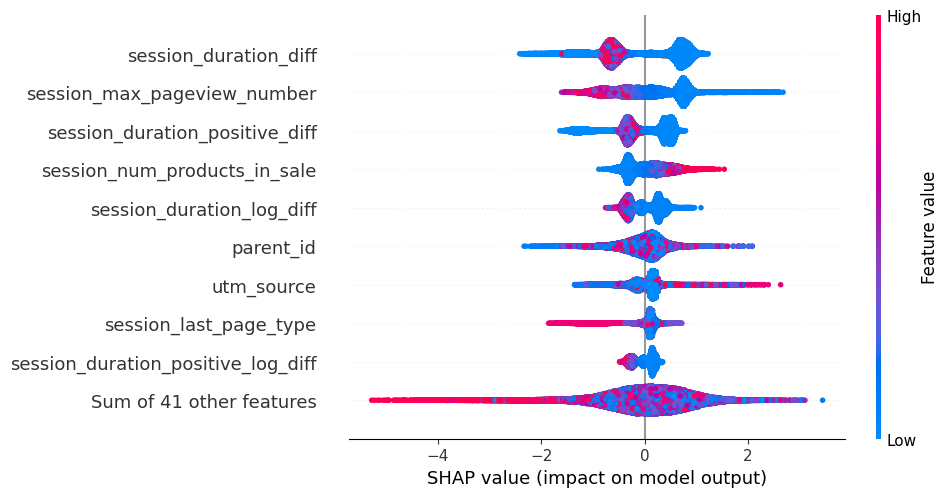

In [51]:
# есть как минимум 2 норм фичи напрямую влияющие на таргет
shap.plots.beeswarm(shap_values_lgbm, max_display=10)

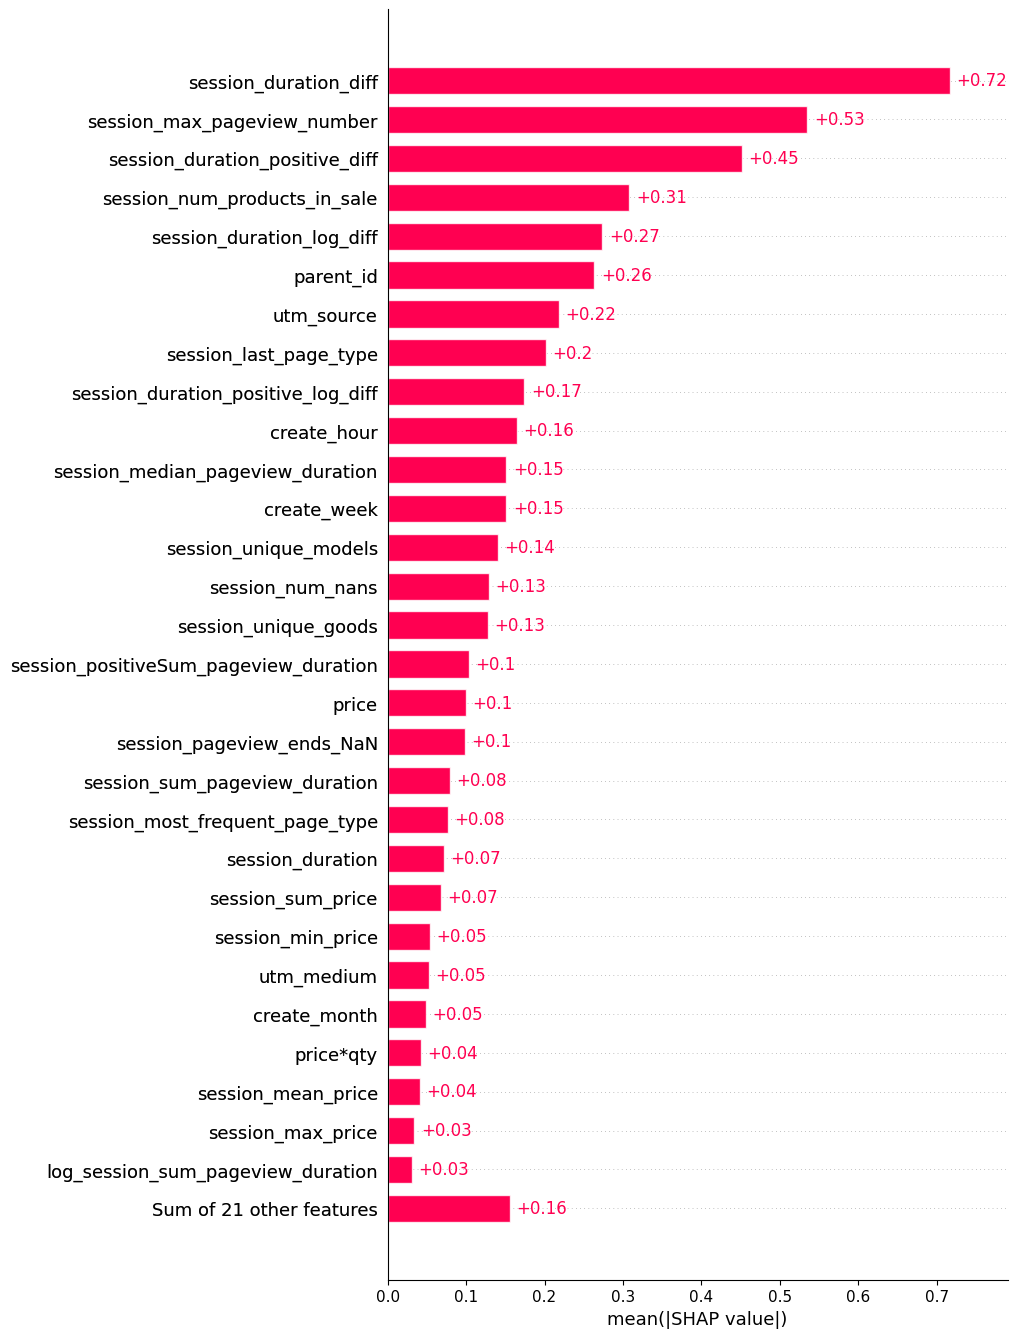

In [50]:
# не смотря на околонормальное распределение лог-фичей, они оказались не особо импактными.
shap.plots.bar(shap_values_lgbm, max_display=30)

In [11]:
# выберем топ-30 влиятельных по SHAP фичей для кластеризации:
top30 = np.abs(shap_values_lgbm.values).mean(axis=0)
top30 = np.argsort(top30)[::-1][:30]
top30 = df_train.drop(['is_callcenter', 'order_id', 'create_time'], axis=1).columns[top30].to_list()

# CLUSTER

In [34]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd, numpy as np
from utils.reductors import *
from utils.drplotter import *
from collections import namedtuple
hue_info = namedtuple('hue_info', ['field_name', 'is_categorical'])

import openTSNE
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from functools import partial


continuous_features = [i for i in top30 if i not in ['is_callcenter', 'order_id', 'create_time']+CAT_FEATURES]
scaled_continuous_features = ['scaled_'+i for i in continuous_features]
df_cluster = df_train.sort_values('create_time')[continuous_features+['is_callcenter']].fillna(df_train[continuous_features].mean()).iloc[-df_train.shape[0]//8:].reset_index(drop=True)
df_cluster[scaled_continuous_features] = StandardScaler().fit_transform(df_cluster[continuous_features])
hover_data = ['scaled_'+i for i in top30[:3]]

mapper_dict = {
    'tsne 2D, init=pca, no affinities': {
        'params': {
           'n_jobs': 4,
           'verbose': False,
           'n_components': 2,
        },
        'func': make_tsne,
        'hue': hue_info('is_callcenter', True),
        'features': scaled_continuous_features,
        'hover_data': hover_data,
    },
    'tsne 2D, init=pca, affinities: perplexity=25, k_neighbors=25': {
        'params': {
           'n_jobs': 4,
           'verbose': False,
           'n_components': 2,
        },
        'func': partial(make_tsne,  
          affinities=openTSNE.affinity.PerplexityBasedNN(df_cluster[scaled_continuous_features].values, perplexity=25, k_neighbors=25, n_jobs=4)
        ),
        'hue': hue_info('is_callcenter', True),
        'features': scaled_continuous_features,
        'hover_data': hover_data,
    },
    'tsne 2D, init=pca, affinities: perplexity=40, k_neighbors=40': {
        'params': {
           'n_jobs': 4,
           'verbose': False,
           'n_components': 2,
        },
        'func': partial(make_tsne,  
          affinities=openTSNE.affinity.PerplexityBasedNN(df_cluster[scaled_continuous_features].values, perplexity=40, k_neighbors=40, n_jobs=4)
        ),
        'hue': hue_info('is_callcenter', True),
        'features': scaled_continuous_features,
        'hover_data': hover_data,
    },
    'UMAP 2D, min_dist=0.05, n_neighbors=10': {
      'params': {
        'n_neighbors': 10,
        'min_dist': 0.05,
        'n_jobs': 4,
        'verbose': False,
        'n_components': 2
      },
      'func': make_umap,

      'hue': hue_info('is_callcenter', True),
      'features': scaled_continuous_features,
      'hover_data': hover_data,
    }, 
    'UMAP 2D, min_dist=0.05, n_neighbors=20': {
      'params': {
        'n_neighbors': 20,
        'min_dist': 0.05,
        'n_jobs': 4,
        'verbose': False,
        'n_components': 2
      },
      'func': make_umap,

      'hue': hue_info('is_callcenter', True),
      'features': scaled_continuous_features,
      'hover_data': hover_data,
    }, 
     'UMAP 2D, min_dist=0.1, n_neighbors=20': {
      'params': {
        'n_neighbors': 20,
        'min_dist': 0.1,
        'n_jobs': 4,
        'verbose': False,
        'n_components': 2
      },
      'func': make_umap,

      'hue': hue_info('is_callcenter', True),
      'features': scaled_continuous_features,
      'hover_data': hover_data,
    }, 
}

drp = DimReductionPlotter()
drp.plot_dim_reduction(
  data=df_cluster,
  mapper_dict=mapper_dict,
  default_features=continuous_features,
  default_hue_info=None,
  row_height=400,
  row_width=1200,
  reuse_results=False
)

100%|██████████| 6/6 [01:40<00:00, 16.80s/it]


Loading BokehJS ...

- для tsne результат очень невнятный, возможно потому, что модель побила лишь только первый бейзлайн и поэтому фичи не так просто разделить (так же я не могу сделать больше perplexity почему-то)
- umap смог выделить целых два островка, но этого кажется совсем мало, чтобы сделать полезную фичу (так же можно зацепить большой шумный синий отросток)

# Watching at some data (skip it)

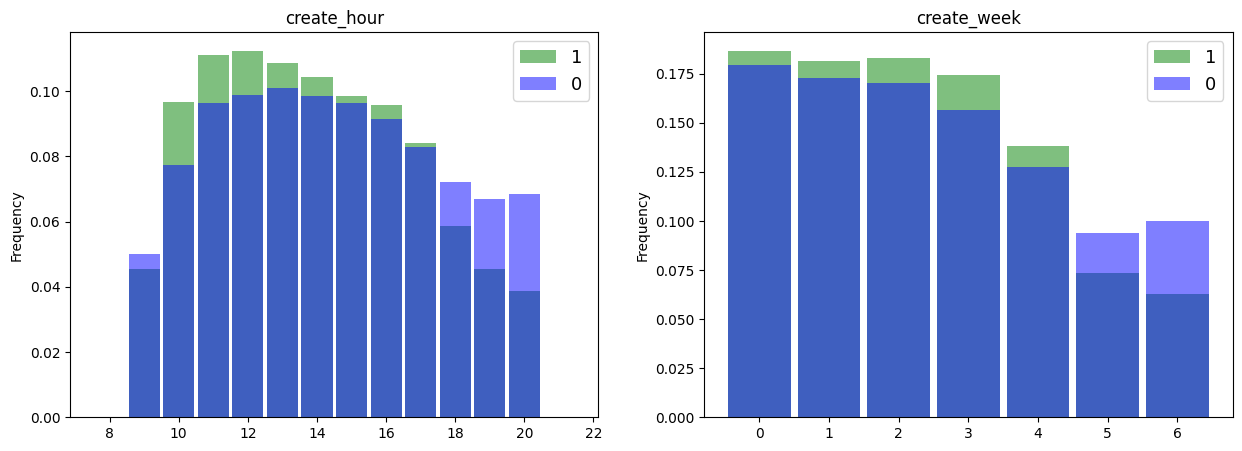

In [5]:
# create_week, create_hour немного полезны на хвостах!
df_train.loc[:,'create_week'] = pd.to_datetime(df_train['create_time']).dt.day_of_week.values
df_train.loc[:,'create_hour'] = pd.to_datetime(df_train['create_time']).dt.hour.values

import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
df_train[df_train['is_callcenter']==1]['create_hour'].plot(kind='hist', weights=np.ones(sum(df_train['is_callcenter']==1))/sum(df_train['is_callcenter']==1), bins=range(8,23), rwidth=0.9, align='left', alpha=0.5, color='g', label='1', ax=ax[0])
df_train[df_train['is_callcenter']==0]['create_hour'].plot(kind='hist', weights=np.ones(sum(df_train['is_callcenter']==0))/sum(df_train['is_callcenter']==0), bins=range(8,23), rwidth=0.9, align='left', alpha=0.5, color='b', label='0', ax=ax[0])
df_train[df_train['is_callcenter']==1]['create_week'].plot(kind='hist', weights=np.ones(sum(df_train['is_callcenter']==1))/sum(df_train['is_callcenter']==1), bins=range(8), rwidth=0.9, align='left', alpha=0.5, color='g', label='1', ax=ax[1])
df_train[df_train['is_callcenter']==0]['create_week'].plot(kind='hist', weights=np.ones(sum(df_train['is_callcenter']==0))/sum(df_train['is_callcenter']==0), bins=range(8), rwidth=0.9, align='left', alpha=0.5, color='b', label='0', ax=ax[1])
ax[0].set_title('create_hour')
ax[1].set_title('create_week')
ax[0].legend()
ax[1].legend();

In [221]:
# для одного и того же sessionkey_id может быть sessionkey_id = 1 и 0 одновременно
weird_mask = df_train.groupby('sessionkey_id')['is_callcenter'].agg(lambda x: sum(list(x))==list(x)[0]*x.shape[0])
df_train[df_train.sessionkey_id==111941362]

order_id          create_time   good_id  price  utm_medium  utm_source  \
68820   1163089  1975-11-03 19:34:56  63004181  13500           8        88.0   
68821   1163036  1975-11-03 19:12:35  26095563  12898           8        88.0   

       sessionkey_id  category_id  parent_id  root_id  model_id  is_moderated  \
68820      111941362          204        202      201  16639638             1   
68821      111941362          204        202      201  16639638             1   

       rating_value  rating_count  description_length  goods_qty  pics_qty  \
68820           5.0           2.0                   0         39         4   
68821           5.0           2.0                   0         39         4   

             model_create_time  is_callcenter  session_duration  
68820  1974-11-18 19:16:48.000              1               0.0  
68821  1974-11-18 19:16:48.000              0               0.0

<Axes: >

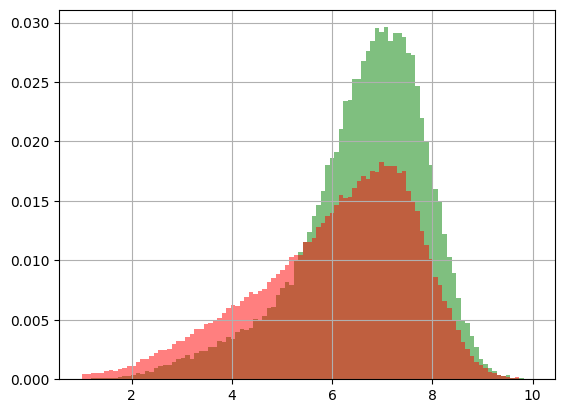

In [5]:
# распределение времени съехало у теста, не очень понятно что с этим можно сделать
df_sessions['date_time'] = pd.to_datetime(df_sessions['date_time'])
maxmindate = df_sessions.groupby('sessionkey_id')['date_time'].apply(lambda x: (x.max()-x.min()).total_seconds())

train_maxmindate = maxmindate[maxmindate.index.isin(df_train.sessionkey_id)]
test_maxmindate  = maxmindate[~maxmindate.index.isin(df_train.sessionkey_id)]
np.log1p(train_maxmindate).reset_index()['date_time'].hist(bins=100, range=(1,10), alpha=0.5, color='g', weights=np.ones(len(train_maxmindate))/len(train_maxmindate))
np.log1p(test_maxmindate).reset_index()['date_time'].hist(bins=100, range=(1,10), alpha=0.5, color='r', weights=np.ones(len(test_maxmindate))/len(test_maxmindate))

In [ ]:
df_sessions[df_sessions.pageview_duration_sec<0].groupby('sessionkey_id').agg(pd.Series)

In [3]:
# pageview_duration_sec спокойно может быть < 0, логика этого непонятна (это вряд ли просто сдвиг на 5 дней)
df_sessions[df_sessions.pageview_duration_sec<0].groupby('sessionkey_id').agg(pd.Series)

date_time  page_type  \
sessionkey_id                                                                 
110328896                                1975-10-19 15:51:10.010          1   
110422717      [1975-10-20 00:37:21.590, 1975-10-20 01:08:05....  [1, 4, 4]   
110467977                                1975-10-20 10:58:39.170          1   
110524430                                1975-10-20 14:34:39.627          3   
110872785                                1975-10-22 00:31:42.277          1   
...                                                          ...        ...   
134595471                                1976-02-16 18:32:02.730          2   
134596933      [1976-02-16 18:34:52.943, 1976-02-16 18:34:59....     [3, 3]   
134609922      [1976-02-16 20:08:51.777, 1976-02-16 20:20:10....     [2, 2]   
134616502                                1976-02-16 20:03:29.110          2   
134621944                                1976-02-16 20:29:41.960          1   

              pageview_number pageview_duration_sec               category_id  \
sessionkey_id                                                                   
110328896                  16                  -1.0                    2873.0   
110422717        [12, 33, 32]   [-6.0, -15.0, -1.0]  [1241.0, 1229.0, 5673.0]   
110467977                   1                  -1.0                    1330.0   
110524430                   2                  -2.0                       NaN   
110872785                  22                  -8.0                    3358.0   
...                       ...                   ...                       ...   
134595471                  19                 -21.0                     155.0   
134596933              [5, 4]          [-6.0, -7.0]                [nan, nan]   
134609922            [23, 46]          [-9.0, -6.0]          [7790.0, 7323.0]   
134616502                   6                  -1.0                     201.0   
134621944                   5                  -3.0                     127.0   

                             model_id                 good_id  \
sessionkey_id                                                   
110328896                    144660.0              65175298.0   
110422717      [16890898.0, nan, nan]  [62773803.0, nan, nan]   
110467977                   3563114.0              20279782.0   
110524430                         NaN                     NaN   
110872785                  22855667.0              58283195.0   
...                               ...                     ...   
134595471                         NaN                     NaN   
134596933                  [nan, nan]              [nan, nan]   
134609922                  [nan, nan]              [nan, nan]   
134616502                         NaN                     NaN   
134621944                   1799088.0              37969387.0   

                           price  product_in_sale  
sessionkey_id                                      
110328896                 1178.0              1.0  
110422717      [732.0, nan, nan]  [1.0, nan, nan]  
110467977                 1099.0              1.0  
110524430                    NaN              NaN  
110872785                  637.0              1.0  
...                          ...              ...  
134595471                    NaN              NaN  
134596933             [nan, nan]       [nan, nan]  
134609922             [nan, nan]       [nan, nan]  
134616502                    NaN              NaN  
134621944                 5331.0              1.0  

[1725 rows x 9 columns]